In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles



In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (15 | units.pc)**3 * ( 2.3 | units.amu * 10 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

7975.78734729


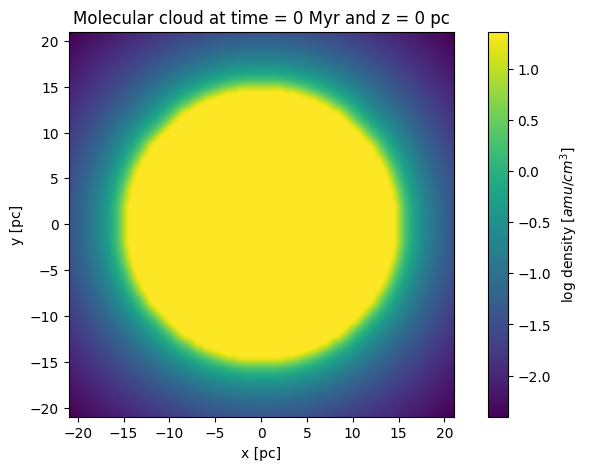

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


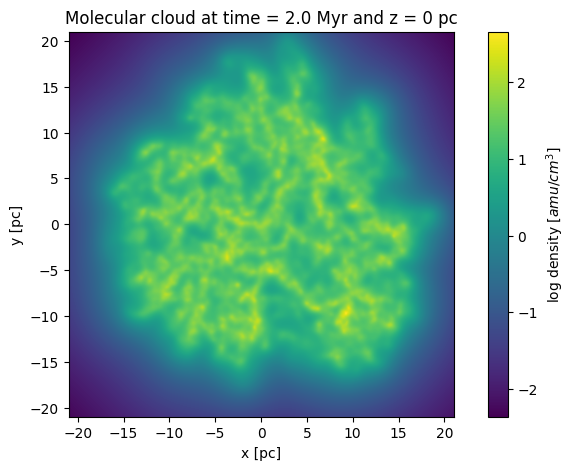

Average mass of a SPH particle 0.03927710488459864.
Mean density of the moelcular cloud 7.2822159097e-20 m**-3 * kg


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 200_000,
                                                         M_cloud = 8_000 | units.MSun,
                                                         R_cloud = 15 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                                    converter_cloud, 
                                                    t_end = 2 | units.Myr, 
                                                    dt = 0.2 | units.Myr, 
                                                    seed = 1312)

print("Mean density of the moelcular cloud", np.mean(particles_cloud.density))

cluster generated


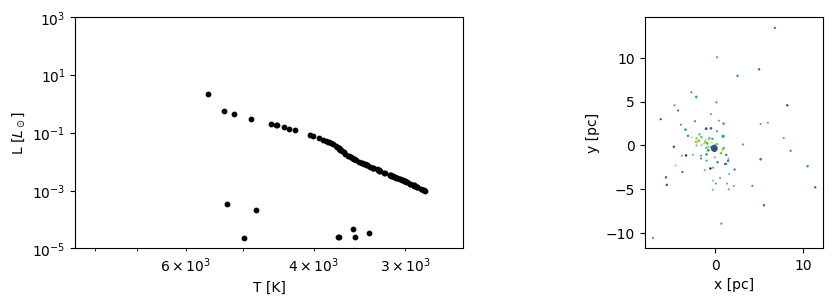

In [13]:
star_cluster = make_globular_cluster(star_count = 100,
                                    imf = "kroupa", 
                                    radius = 4 | units.pc,
                                    metallicity = 0.002, 
                                    age = 10 | units.Gyr, 
                                    seed = 1312)

converter_cluster = nbody_system.nbody_to_si(star_cluster.mass.sum(), 
                                   star_cluster.position.sum())

In [9]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                          # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [7]:
# # initialise the star particle set
# star = Particles(1)
# star.name = "star"
# star.mass = 0.7 |units.MSun
# star.radius = star.mass[0].value_in(units.MSun)**0.8 | units.RSun
# star.position = (-1.0, 0, 0) * (17 | units.pc)
# star.velocity = (1.0, 0, 0) * (20| units.kms)
# inital_mass = np.copy(star.mass)
# converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
#                                    star.position.sum())

In [20]:
star_cluster.position +=  (-1.0, 0, 0) * (30 | units.pc)
star_cluster.velocity += (1.0, 0, 0) * (20| units.kms)

In [21]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_cluster)
sinks = new_sink_particles(star_cluster)

gravity_code.particles.add_particles(sinks)

In [22]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"to_sinks": gravity_code.particles.new_channel_to(sinks),
           "from_sinks": sinks.new_channel_to(gravity_code.particles),
           "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

In [23]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [24]:
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM

In [26]:
sinks.mass

quantity<[0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602, 0.400088850085, 0.131785189635, 0.152123031697, 0.128588193095, 0.101109819384, 0.129446502993, 0.867465869565, 0.310879588063, 0.173638070438, 0.565597058926, 0.159705918177, 0.70260365227, 0.141657505096, 0.14058917033, 0.301459580903, 0.1362113794, 0.195814825421, 0.479282457184, 0.18587109461, 0.426996654511, 0.765430648957, 0.507524939393, 0.122835866424, 0.205787829328, 0.2454765051, 0.44849563291, 0.594513497377, 0.112062982216, 0.540384409247, 0.440765604432, 0.382317566883, 0.147568412083, 0.123582423321, 0.517116322926, 0.247149960975, 0.133029662043, 0.722959429179, 0.446280225063, 0.687108074554, 0.217503518873, 0.158536648622, 0.236395838547, 0.421336853402, 0.151004998399, 1.01829891793, 0.289063478804, 1.07681457258, 0.576721573944, 0.536245833087, 0.112642998753, 0.13736317818, 0.836858442993, 0.32515597888

In [28]:
print((bondi_radius(sinks.mass)).value_in(units.pc))

[ 0.05065076  0.11332027  0.06148115  0.11452257  0.02855502  0.03389602
  0.03145057  0.36114659  0.12556288  0.02528885  0.08605927  0.02834705
  0.03272172  0.02765937  0.02174876  0.02784399  0.18659225  0.06687032
  0.03734962  0.12166015  0.03435281  0.15113032  0.03047058  0.03024079
  0.06484407  0.02929912  0.04211985  0.10309384  0.03998094  0.09184715
  0.16464443  0.10916881  0.02642204  0.04426504  0.05280209  0.09647159
  0.12788008  0.02410479  0.1162369   0.09480885  0.08223666  0.03174202
  0.02658263  0.11123192  0.05316205  0.02861473  0.15550885  0.09599505
  0.14779721  0.04678509  0.03410129  0.05084884  0.09062972  0.03248123
  0.21903649  0.06217767  0.23162323  0.12405304  0.11534669  0.02422955
  0.02954687  0.18000858  0.06994118  0.03204596  0.02516562  0.05981096
  0.17018924  0.03497109  0.02400281  0.13389582  0.07116119  0.04877823
  0.03474149  0.02234159  0.04908277  0.06243988  0.03761346  0.15886825
  0.05650505  0.04072386  0.15571421  3.41819566  0

In [13]:
print(len(particles_cloud.mass))
print(particles_cloud.mass.sum().value_in(units.MSun))
print(sink.mass)

203681
8000.0
[0.7] MSun


Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.1  Myr. Now located at [-28.57431828 -29.19874621 -28.31675905 -33.60047758 -28.43013325
 -29.52062162 -26.4914071  -27.07532051 -29.03897997 -30.084001  ] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203681 number of cloud particles now


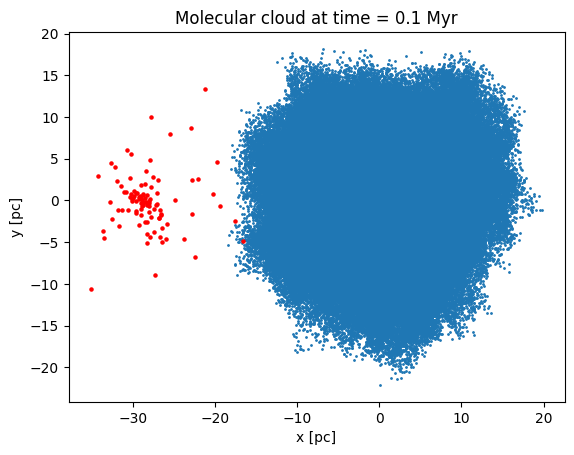

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.2  Myr. Now located at [-26.62076372 -27.12729928 -26.35547504 -31.57025288 -26.33700755
 -27.5143764  -24.50033421 -25.02768314 -27.05985394 -28.07918347] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203681 number of cloud particles now


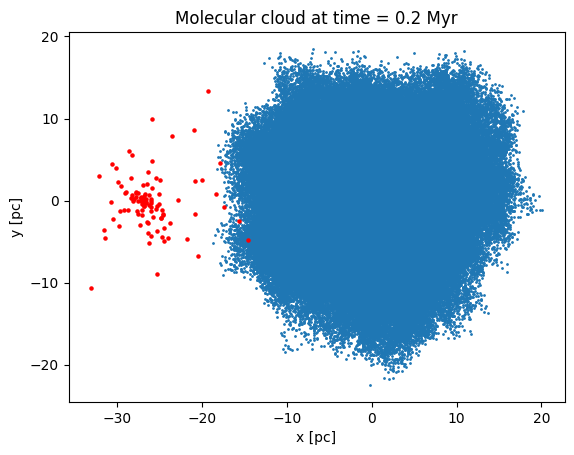

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.3  Myr. Now located at [-24.66670144 -25.05536227 -24.39368167 -29.53966992 -24.24337882
 -25.50768787 -22.50872591 -22.97947655 -25.08023675 -26.07390739] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203681 number of cloud particles now


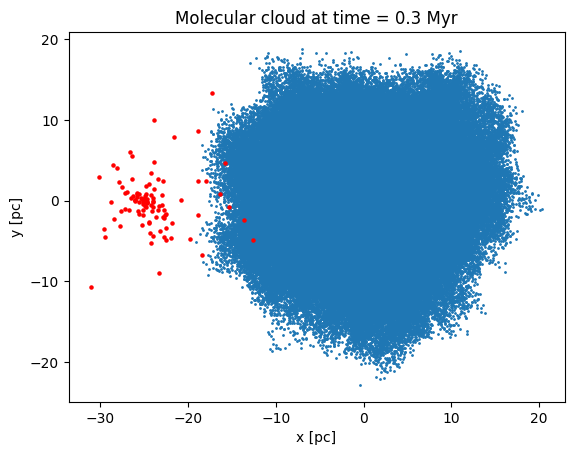

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.4  Myr. Now located at [-22.71205021 -22.98285287 -22.43129828 -27.5086796  -22.1491618
 -23.50049203 -20.51649783 -20.93060242 -23.10005013 -24.06810115] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203681 number of cloud particles now


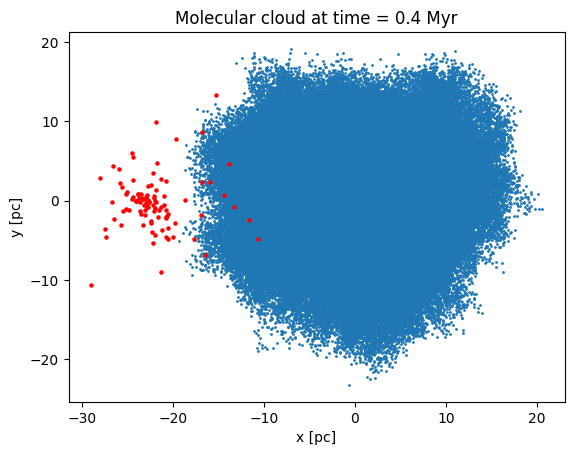

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.5  Myr. Now located at [-20.75671412 -20.90967163 -20.46822926 -25.4772222  -20.05425295
 -21.49271388 -18.52355067 -18.88094172 -21.11920041 -22.06167716] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203670 number of cloud particles now


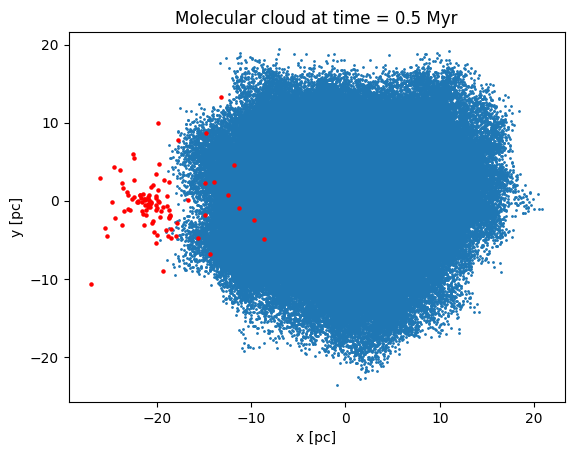

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.6  Myr. Now located at [-18.8005773  -18.83569801 -18.50436213 -23.44522436 -17.95852932
 -19.48426278 -16.5297773  -16.83036299 -19.13757466 -20.05453079] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
203566 number of cloud particles now


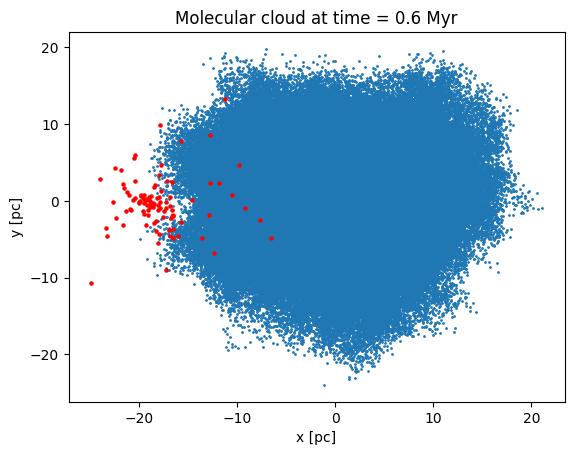

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.7  Myr. Now located at [-16.84351353 -16.76079879 -16.53957631 -21.41259734 -15.8618636
 -17.47503885 -14.53507299 -14.77874262 -17.15504718 -18.04653879] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
202649 number of cloud particles now


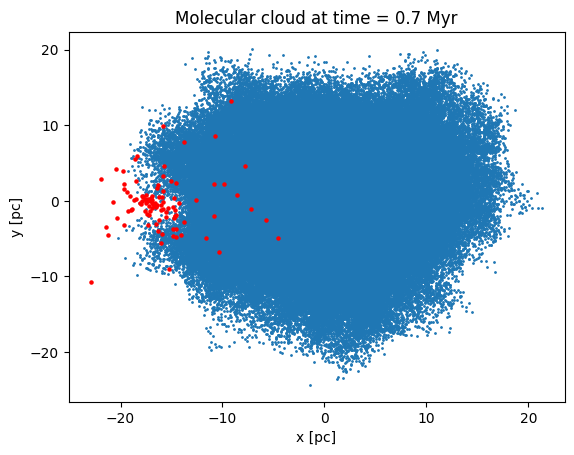

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.8  Myr. Now located at [-14.88540415 -14.68484899 -14.57375987 -19.37923298 -13.7641476
 -15.4649421  -12.53936714 -12.72599338 -15.1714953  -16.03757079] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
158122 number of cloud particles now


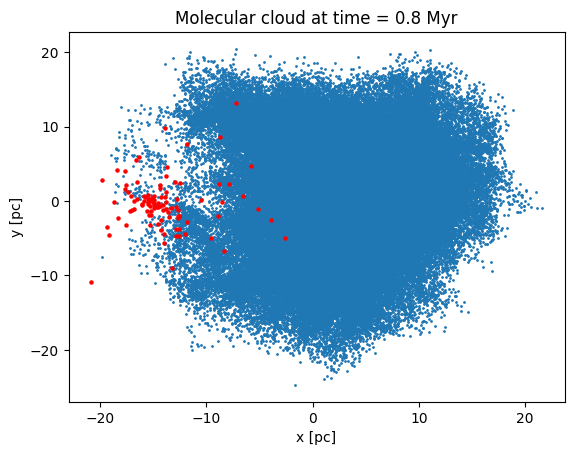

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 0.9  Myr. Now located at [-12.9260747  -12.60767282 -12.60675218 -17.3449222  -11.66525287
 -13.45382508 -10.54258847 -10.6720218  -13.18673514 -14.02742526] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
0 number of cloud particles now


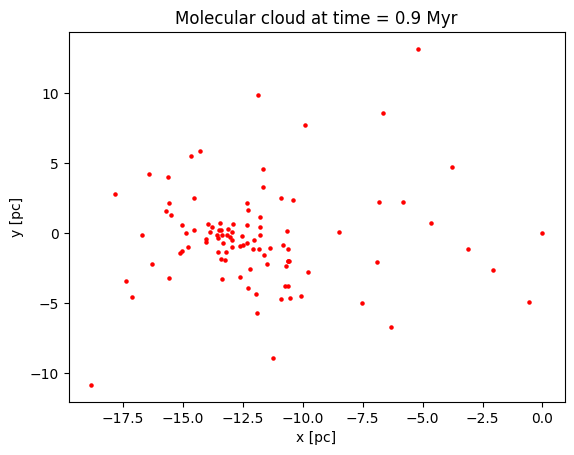

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
Sinks in progress at 1.0  Myr. Now located at [-10.96512035 -10.52887203 -10.63816951 -15.3092399   -9.56483989
 -11.44134411  -8.54446422  -8.61649663 -11.20035503 -12.01567506] pc.
post accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun
0 number of cloud particles now


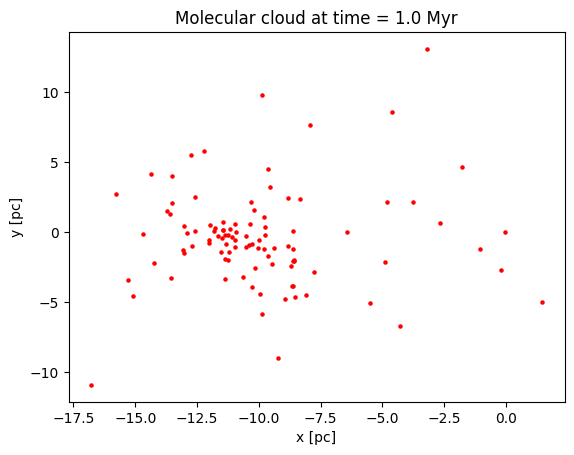

Sinks radius [0.0506507584095, 0.113320273497, 0.0614811488888, 0.114522574004, 0.0285550246725, 0.0338960172295, 0.0314505748292, 0.361146592332, 0.125562882976, 0.0252888521418] parsec
pre accretion [0.235474973256, 0.526825050778, 0.28582537251, 0.53241453628, 0.132752082737, 0.157582314683, 0.146213472401, 1.67896763723, 0.58374084494, 0.117567672602] MSun


KeyboardInterrupt: 

In [29]:
t_end = 4 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

# L = int(abs(sinks.position.sum().value_in(units.pc)))*1.2
# N = 500

sinks_mass_snapshots = []

while model_time < t_end:
    # define the accreting radius of the sinks particle based on its Bondi radius
    # IMPORTANT: the mass changes after each accretion event
    sinks.sink_radius = bondi_radius(sinks.mass)

    print("Sinks radius", sinks.sink_radius[:10].in_(units.pc))

    print("pre accretion",sinks.mass[:10])
    
    model_time += dt
    model_time = model_time.round(1)
    # evolve the gravity and hydro codes through our bridge
    gravhydrobridge.evolve_model(model_time)


    # update channels (copy over from the codes.particles to the particle sets)
    channel["to_sinks"].copy()
    channel["to_cloud"].copy()

    print("Sinks in progress at", model_time.value_in(units.Myr), " Myr. Now located at", sinks.x[:10].value_in(units.pc), "pc.")
    # add the acretted mass to the sinks's total mass
    sinks.accrete(particles_cloud)
    # update channels (copy the information from the particle set to the gravity code)
    channel["from_sinks"].copy()
    # save the total mass of each step
    sinks_mass_snapshots.append(sinks.mass.value_in(units.MSun))

    print("post accretion",sinks.mass[:10])
    print(len(particles_cloud.mass), "number of cloud particles now")

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.scatter(sinks.x.value_in(units.pc), sinks.y.value_in(units.pc), c = 'red', s = 5)
    plt.title("Molecular cloud at time = " + model_time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()


In [39]:
sinks_mass_snapshots[0] - sinks_mass_snapshots[-1]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

100

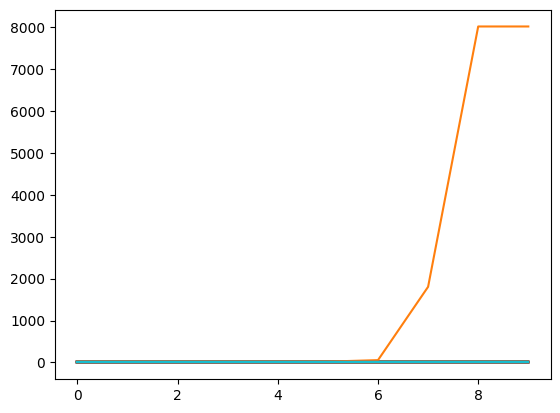

In [31]:
plt.plot(sinks_mass_snapshots)
plt.show()

In [ ]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()